# 자전거 수요 예측
- [csv 파일](https://www.kaggle.com/c/bike-sharing-demand/data)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

bike_df = pd.read_csv('../data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## 데이터 전처리 1
- datetime에서 년월일, 시간 추출 후 새로운 column 생성
- casual + registered = count이므로 상관관계가 높기 때문에 casual, registered 삭제

In [3]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [4]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

## 성능 평가 함수
- RMSLE (Root Mean Square Log Error) : 오류 값의 로그에 대한 RMSE, 사이킷런에서 제공하지 않으므로 직접 함수 생성

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# value가 0일 경우 log를 취하면 overflow가 일어날 수 있으므로 log1p (log(x+1))을 이용하여 rmsle 계산
# 사이킷런의 mean_squared_log_error 또한 log로 계산하므로 직접 함수를 만들어주기
# expm1() 함수를 이용하여 원래 스케일로 복원 가능
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print(f'RMSLE : {rmsle_val:.3f}, RMSE : {rmse_val:.3f}, MAE : {mae_val:.3f}')

## 데이터 전처리 2
- 로그 변환
- 인코딩

### 데이터 전처리 전 테스트

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


In [13]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


### 오차가 클 때
- 가장 먼저 target의 데이터 분포를 확인하여 정규 분포 모양인지 확인

<AxesSubplot:>

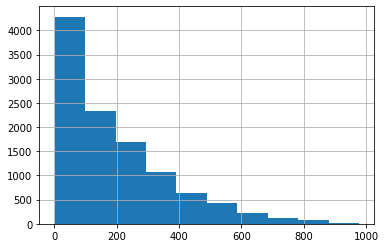

In [14]:
y_target.hist()

### 로그 변환 후

<AxesSubplot:>

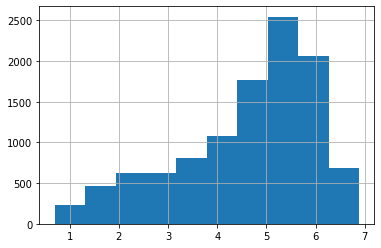

In [15]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

### 로그 변환 후 학습

In [16]:
y_target_log = y_log_transform

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,
                                                   test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# target은 log 변환된 상태이므로 원상태로 변환
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_test)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


RMSE는 오히려 늘어남

<AxesSubplot:>

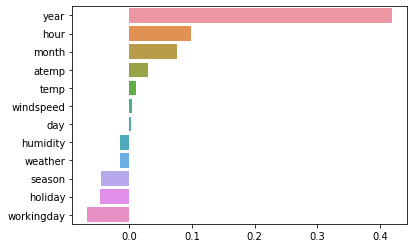

In [17]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 데이터 전처리 3
- 숫자형 카테고리 feature는 선형 회귀에 영향을 많이 주기 때문에 one-hot encoding을 적용하여 변환

In [18]:
category_columns = ['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather']
X_features_ohe = pd.get_dummies(X_features, columns=category_columns)

# 학습 및 평가
- 선형 회귀
- 릿지
- 라쏘

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                   test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        pred = np.expm1(pred)
        y_test = np.expm1(y_test)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

In [20]:
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 97.745, MAE : 63.416
### Lasso ###
RMSLE : 1.240, RMSE : 177.722, MAE : 121.342


<AxesSubplot:>

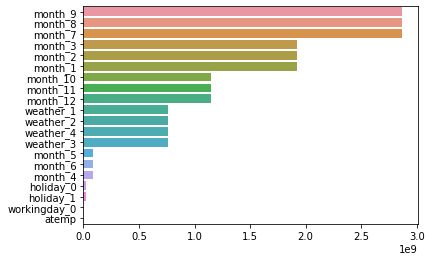

In [22]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 학습 및 평가
- 회귀 트리

In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # 버전에 따라 xgboost는 dataframe으로 넣으면 오류 발생하므로 array로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.275, MAE : 31.066
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.328, MAE : 32.734
### XGBRegressor ###
RMSLE : 0.342, RMSE : 51.732, MAE : 31.251
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029
